Here we are comparing the effect of reconstructing noisy fragments of a raccoon face image using firstly online Dictionary Learning and for that we are extracting the patches using extract_patches and then reconstructing images using reconstruct_from_patches. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

In [3]:
from skimage import color
from skimage import io

#### Loading the image
Source: https://pixabay.com/images/id-1757179/

In [7]:
color_img = io.imread('datasets/koala.jpg')

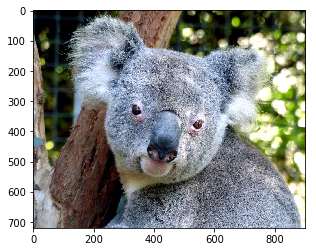

In [8]:
plt.imshow(color_img, cmap=plt.cm.gray)

plt.show()

#### Convert image to grayscale

In [9]:
img = color.rgb2gray(color_img)

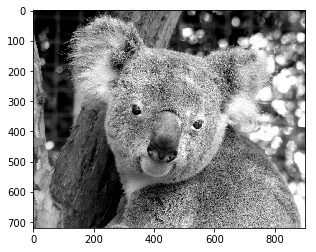

In [10]:
plt.imshow(img, cmap=plt.cm.gray)

plt.show()

In [12]:
img.shape  # Height and Width dimension

(720, 902)

In [13]:
height, width = img.shape

#### Create a copy of the image

In [15]:
img

array([[0.23508667, 0.18607843, 0.11410627, ..., 0.12523961, 0.15800392,
        0.20645451],
       [0.26645922, 0.19587098, 0.10961137, ..., 0.11683098, 0.15351686,
        0.20477294],
       [0.25664392, 0.18802784, 0.1056898 , ..., 0.14175216, 0.17116039,
        0.20420745],
       ...,
       [0.2650498 , 0.24797961, 0.30736863, ..., 0.99438902, 0.99438902,
        0.99438902],
       [0.22191255, 0.21546824, 0.25638824, ..., 0.99438902, 0.99438902,
        0.99438902],
       [0.19446157, 0.19193882, 0.19364314, ..., 0.99438902, 0.99438902,
        0.99438902]])

In [16]:
distorted_img = img.copy()

In [17]:
distorted_img

array([[0.23508667, 0.18607843, 0.11410627, ..., 0.12523961, 0.15800392,
        0.20645451],
       [0.26645922, 0.19587098, 0.10961137, ..., 0.11683098, 0.15351686,
        0.20477294],
       [0.25664392, 0.18802784, 0.1056898 , ..., 0.14175216, 0.17116039,
        0.20420745],
       ...,
       [0.2650498 , 0.24797961, 0.30736863, ..., 0.99438902, 0.99438902,
        0.99438902],
       [0.22191255, 0.21546824, 0.25638824, ..., 0.99438902, 0.99438902,
        0.99438902],
       [0.19446157, 0.19193882, 0.19364314, ..., 0.99438902, 0.99438902,
        0.99438902]])

Distort the right half of the image

In [23]:
distortion = 0.075 * np.random.randn(height, width // 2)

distortion.shape  # New distorted shape

(720, 451)

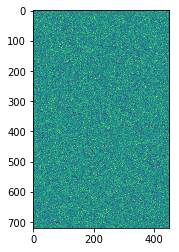

In [25]:
plt.imshow(distortion)

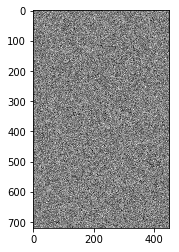

In [26]:
plt.imshow(distortion, cmap='gray')

plt.show()

In [27]:
distorted_img[:, width // 2:] += distortion

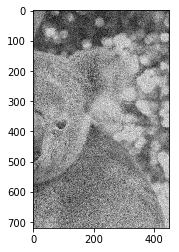

In [28]:
plt.imshow(distorted_img[:, width // 2:], cmap=plt.cm.gray)

plt.show()

#### View the full image
The left half is sharper than the right one, though the difference is subtle. 

The goal is to reconstruct the right half of the image by extracting patches from this distorted right half and combining it with the atoms extracted from the left half.

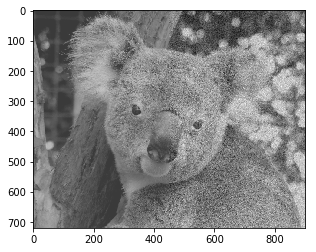

In [29]:
plt.imshow(distorted_img, cmap=plt.cm.gray)

plt.show()

#### Extract patches of 7x7 for the clean left half of the image
The extract_patches_2d function extracts all possible patches of size 7x7 from the image. Since we're working with half of the image, the dimensions of this half are (720, 451). The number of possible patches of 7x7 are (720-6)x(451-6) = 317,730. 

In [30]:
patch_size = (7, 7)

data = extract_patches_2d(distorted_img[:, :width // 2], patch_size)

In [31]:
data.shape

(317730, 7, 7)

#### View one of the patches

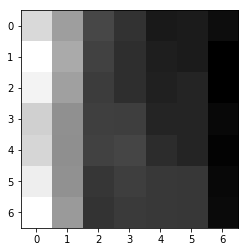

In [32]:
plt.imshow(data[0], cmap=plt.cm.gray)

plt.show()

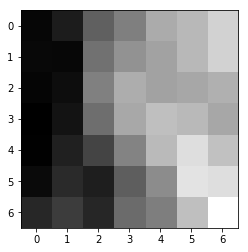

In [34]:
plt.imshow(data[1150], cmap=plt.cm.gray)

plt.show()

In [35]:
data = data.reshape(data.shape[0], -1)

In [36]:
data.shape

(317730, 49)

#### Learn the dictionary from reference patches

#### MiniBatchDictionaryLearning
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchDictionaryLearning.html

In [39]:
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [40]:
d_learning = MiniBatchDictionaryLearning(n_components=100, 
                                         alpha=1, 
                                         n_iter=1000)

components = d_learning.fit(data).components_

components

array([[ 0.16047301,  0.15861886,  0.1534696 , ...,  0.14253325,
         0.13064037,  0.12196103],
       [ 0.13740995,  0.13836894,  0.14099802, ...,  0.14766542,
         0.14981281,  0.15041018],
       [ 0.13401399,  0.14163483,  0.14709391, ...,  0.16157108,
         0.16977484,  0.16643204],
       ...,
       [-0.19271301,  0.09027172,  0.08621024, ...,  0.04087352,
        -0.16152776,  0.01664769],
       [ 0.1848119 ,  0.00055791, -0.12171925, ..., -0.07414429,
        -0.14091655,  0.26512131],
       [ 0.08603293,  0.00852482,  0.15146931, ..., -0.13241666,
         0.05166439, -0.14585681]])

In [41]:
components.shape

(100, 49)

#### Dictionary learned from patches of the left half of the image
Each component is a 7x7 patch

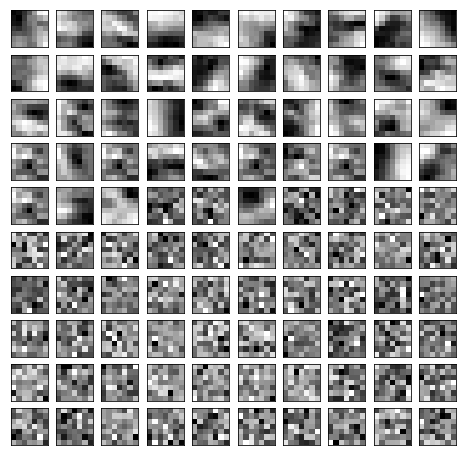

In [42]:
plt.figure(figsize=(8, 8))

for i, comp in enumerate(components):
    
    plt.subplot(10, 10, i + 1)
    
    plt.imshow(comp.reshape(patch_size), 
               cmap=plt.cm.gray_r,
               interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
    
plt.show()

#### Get patches for right half of image
These patches for the distorted image. We extract these patches and then feed them into our trained Dictionary Learner

In [43]:
right_data = extract_patches_2d(distorted_img[:, width // 2:], patch_size)

In [44]:
right_data = right_data.reshape(right_data.shape[0], -1)

right_data.shape

(317730, 49)

Reconstruct using the dictionary. Here we set transform_n_nonzero_coefs = 1, transform_algorithm = 'omp'

In [45]:
d_learning.set_params(transform_n_nonzero_coefs = 1, 
                      transform_algorithm = 'lars')

# TODO (for recording): First show 'lars' and then 'omp'
# d_learning.set_params(transform_n_nonzero_coefs = 1, 
#                       transform_algorithm = 'omp'

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
                            fit_algorithm='lars', n_components=100, n_iter=1000,
                            n_jobs=None, positive_code=False,
                            positive_dict=False, random_state=None,
                            shuffle=True, split_sign=False,
                            transform_algorithm='lars', transform_alpha=None,
                            transform_max_iter=1000,
                            transform_n_nonzero_coefs=1, verbose=False)

#### Encode the data
Encode the data as a sparse combination of the dictionary atoms

In [46]:
code = d_learning.transform(right_data)

#### The shapes of the code and components arrays
The arrays are compatible for the generation of a dot product

In [47]:
print('Shape of code: ', code.shape)
print('Shape of components: ', components.shape)

Shape of code:  (317730, 100)
Shape of components:  (100, 49)


#### Build the image patches from the atoms

In [48]:
patches = np.dot(code, components)
patches.shape

(317730, 49)

#### Reshape the patches 
So that the original image can be reconstructed from them

In [49]:
patches = patches.reshape(len(right_data), *patch_size)
patches.shape

(317730, 7, 7)

#### Initialize the reconstructed image
For now we create a copy of the original image. We will overlay the right half of the image which will be reconstructed from the patches on this image copy

In [50]:
reconstructed_img = img.copy()

In [51]:
reconstructed_img[:, width // 2:] = \
    reconstruct_from_patches_2d(patches, (height, width // 2))

#### Overlay the reconstructed image on the original copy
The right half has been built from the distorted patches on the right half of the image plus the atoms derived from the left half

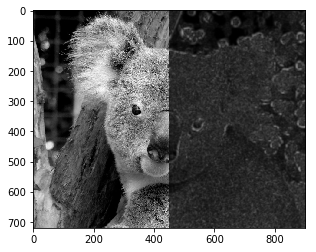

In [54]:
plt.imshow(reconstructed_img, 
           vmin=0, 
           vmax=1, 
           cmap=plt.cm.gray,
           interpolation='nearest')

plt.show()

Evaluating the results of image denoising by looking at the difference between the reconstruction and the original image. If the reconstruction is perfect this will look like Gaussian noise.

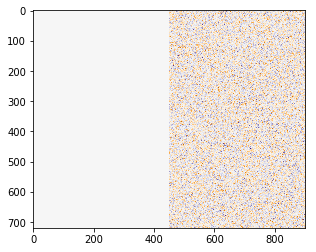

In [57]:
difference = img - distorted_img

plt.imshow(difference, 
           vmin=-0.5, 
           vmax=0.5, 
           cmap=plt.cm.PuOr, 
           interpolation='nearest')

plt.show()

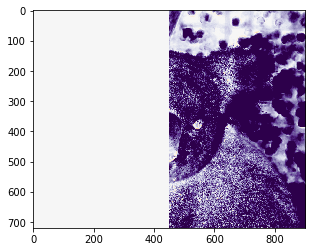

In [58]:
difference = img - reconstructed_img

plt.imshow(difference, 
           vmin=-0.5, 
           vmax=0.5, 
           cmap=plt.cm.PuOr, 
           interpolation='nearest')

plt.show()